# VAE on the real BACMMAN dataset

In [3]:
!nvidia-smi

# DRIVE
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/BACMMAN_DISTNET/')

!pip install git+https://github.com/jeanollion/dataset_iterator.git
!pip install git+https://github.com/jeanollion/distnet.git
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt

from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

# copy data locallly
dataset_dir = f"/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/"
!cp "/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/train_val_eval.h5" "/home/train_val_eval.h5"
dataset_path = "/home/train_val_eval.h5"
print(dataset_path)

Fri Aug 14 09:43:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/home/train_val_eval.h5


## Load datasets

In [4]:
# concatenate evaluation sets (norm only and anormal only) into a single h5
# file --> more convenient to load them into a single iterator after

from dataset_iterator import MultiChannelIterator, PreProcessingImageGenerator

eval_set_path = "/home/eval_set.h5"

# evaluation set, nominal and anormal classes ()
x_test_norm = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "eval_norm",
                                input_channels=[0],
                                output_channels=[0], 
                                batch_size=64
                                )

x_test_anorm = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "eval_anom",
                                input_channels=[0],
                                output_channels=[0], 
                                batch_size=64
                                )


def get_images(iterator):
    images = []
    for i in range(len(iterator)):
        bx, by = iterator[i]
        for im in bx:
            images.append(im)
    return np.array(images)

# get images
nominal_images = get_images(x_test_norm)
n_nominal = nominal_images.shape[0]
print(f"{n_nominal} nominal images")
anormal_images = get_images(x_test_anorm)
n_anormal = anormal_images.shape[0]
print(f"{n_anormal} anormal images")

with h5py.File(eval_set_path, 'w') as out_file:
    out_file.create_dataset("eval/0/raw", data=get_images(x_test_norm))
    out_file.create_dataset("eval/0/labels", data=np.zeros(n_nominal))
    out_file.create_dataset("eval/1/raw", data=get_images(x_test_anorm))
    out_file.create_dataset("eval/1/labels", data=np.array([1 for i in range(n_anormal)]))

851 nominal images
1011 anormal images


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from distnet.utils.pre_processing import random_scaling
from dataset_iterator.helpers import get_min_and_max

corruption_function = lambda im: im + np.random.uniform(0, 0, im.shape) 

def global_contrast_normalization(im, s=1, lmda=1, epsilon=1e-9):
    mu = np.mean(im)
    im = im - mu
    contrast = np.sqrt(lmda + np.mean(im**2))
    im = s * im / max(contrast, epsilon)
    return im

data_gen_train = ImageDataGenerator(
                                horizontal_flip=True,
                                # vertical_flip=True,
                                # height_shift_range=0.2,
                                # channel_shift_range=0.2,
                                fill_mode="nearest",)

def corruption_mm_scaling(batch_by_channel):
    minpix, maxpix = np.amin(batch_by_channel[0]), np.amax(batch_by_channel[0])
    batch_by_channel[0] = (batch_by_channel[0] - minpix) / (maxpix - minpix)
    batch_by_channel[1] = np.copy(batch_by_channel[0]) # creating channel 1
    batch_by_channel[0] = corruption_function(batch_by_channel[0])  # corruption on channel 0 only


def mm_scaling(batch_by_channel):
    minpix, maxpix = np.amin(batch_by_channel[0]), np.amax(batch_by_channel[0])
    batch_by_channel[0] = (batch_by_channel[0] - minpix) / (maxpix - minpix)


def normalization(batch_by_channel, axis=0):
    if axis is None:
        mu, sig = batch_by_channel[0].mean(), batch_by_channel[0].std()
    else:
        mu, sig = batch_by_channel[0].mean(axis=axis), batch_by_channel.std(axis=axis)
    batch_by_channel[0] = (batch_by_channel[0] - mu) / sigma

In [6]:
# train set, interest class only ([augmentation + corruption, augmentation without corruption])
x_train = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw", None],
                                group_keyword = "train", 
                                input_channels=[0],
                                output_channels=[1], 
                                image_data_generators=[data_gen_train, None],
                                channels_postprocessing_function=corruption_mm_scaling,
                                batch_size=100
                                )

# validation set, interest class only ([augmentation without corruption])
x_val = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "val",
                                input_channels=[0],
                                output_channels=[0], 
                                channels_postprocessing_function=mm_scaling,
                                batch_size=100
                                )

# evaluation set, nominal and anormal classes ()
x_test = MultiChannelIterator(dataset=eval_set_path, 
                                channel_keywords=["/raw", "/labels"],
                                group_keyword = ["eval/{}/".format(lab) for lab in range(2)],
                                input_channels=[0],
                                output_channels=[0, 1],
                                channels_postprocessing_function=mm_scaling, 
                                batch_size=64
                                )

print(f"Number of batches {len(x_train)} of size {len(x_train[0][0])}")

Number of batches 100 of size 100


## Build model

In [33]:
from uad.models.architecture import get_unet_vae

n_filters = 64
n_contractions = 5
input_dims = (256, 32, 1)
latent_depth = n_filters * int(2**n_contractions)
latent_dims = (int(256 / (2**n_contractions)), int(32 / (2**n_contractions)), latent_depth)
batchnorm, dropout, spatial_dropout = False, 0.2, 0
activation_function = "leaky_relu"
k_size = (3, 3)
self_attention = False
final_activation, layer_norm = "", False


encoder, decoder = get_unet_vae(n_filters=n_filters, n_contractions=n_contractions,
                                input_dims=input_dims, k_size=k_size, batchnorm=batchnorm,
                                dropout=dropout, spatial_dropout=spatial_dropout,
                                activation_function=activation_function, latent_depth=latent_depth,
                                self_attention=self_attention, layer_norm=layer_norm)

print(encoder.summary(), decoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 256, 32, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 256, 32, 64)  640         encoder_inputs[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_60 (LeakyReLU)      (None, 256, 32, 64)  0           conv2d_60[0][0]                  
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 256, 32, 64)  36928       leaky_re_lu_60[0][0]             
____________________________________________________________________________________________

In [34]:
from uad.models.variational_autoencoder import VAE

vae = VAE(encoder, decoder, dims=(256, 32, 1), reconstruction_loss="mse", BETA=1)

# import os
# os.chdir("/content/drive/My Drive/BACMMAN_DISTNET/models/")
# # vae = tf.keras.models.load_model("vae_unet_BACT_weights_5contr_kl1")
# vae.load_weights("vae_unet_BACT_weights_5contr_kl1")

In [38]:
epochs = 20

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard


vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto',
    min_delta=0.1, cooldown=0, min_lr=1e-8,)

checkpoint_path = "/content/drive/My Drive/BACMMAN_DISTNET/models/vae_unet_BACT_weights_5contr_kl1"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=1000,
                                                 save_best_only=False)

import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

history = vae.fit(x_train, validation_data=x_val, epochs=epochs,  # 35 epochs seeems sufficient
                  callbacks=[tensorboard_callback, cp_callback, reduce_lr])

Epoch 1/20
100/100 [==============================] - 83s 826ms/step - loss: 21.9242 - reconstruction_loss: 21.3798 - kl_loss: 0.5444 - val_loss: 26.2453 - val_reconstruction_loss: 25.3700 - val_kl_loss: 0.8752
Epoch 2/20
100/100 [==============================] - 85s 850ms/step - loss: 8.1791 - reconstruction_loss: 7.5033 - kl_loss: 0.6758 - val_loss: 33.0847 - val_reconstruction_loss: 32.2111 - val_kl_loss: 0.8736
Epoch 3/20
100/100 [==============================] - 86s 861ms/step - loss: 7.3957 - reconstruction_loss: 6.7142 - kl_loss: 0.6814 - val_loss: 9.3842 - val_reconstruction_loss: 8.7312 - val_kl_loss: 0.6530
Epoch 4/20
100/100 [==============================] - 87s 871ms/step - loss: 7.0767 - reconstruction_loss: 6.4003 - kl_loss: 0.6765 - val_loss: 11.1945 - val_reconstruction_loss: 10.3919 - val_kl_loss: 0.8026
Epoch 5/20
100/100 [==============================] - 88s 875ms/step - loss: 6.9557 - reconstruction_loss: 6.2990 - kl_loss: 0.6567 - val_loss: 7.7779 - val_reconst

In [ ]:
from sklearn.metrics import auc

epochs = 50

auc_scores = np.zeros(10)
for i in range(9): # 10 replicas
    encoder, decoder = get_unet_vae(n_filters=n_filters, n_contractions=n_contractions,
                                input_dims=input_dims, k_size=k_size, batchnorm=batchnorm,
                                dropout=dropout, spatial_dropout=spatial_dropout,
                                activation_function=activation_function, latent_depth=latent_depth,
                                self_attention=self_attention, layer_norm=layer_norm)
    model = VAE(encoder, decoder, dims=(256, 32, 1), reconstruction_loss="mse", BETA=1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
    model.fit(x_train, validation_data=x_val, epochs=epochs,  # 35 epochs seeems sufficient
                  callbacks=[reduce_lr], verbose=0)
    fpr, tpr, _ = compute_ROC_iterator(model, x_test, interest_digit=0)
    auc = auc(fpr, tpr)
    print(f"Iteration {i}, Final AUC: {auc}")
    auc_scores[i] = auc

print(auc_scores)
np.save("/content/gdrive/My Drive/BACMMAN_DISTNET/models/auc_per_class_MNIST_10replicas", auc_scores)


Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
(1862,) [2.4078496 1.882369  3.215966  3.876471  2.0585215 2.5550148 1.8866731
 3.3553026 3.3206167 3.7196198]
Iteration 0, Final AUC: 0.964991439639872

Epoch 00022: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
(1862,) [2.1293635 1.4167424 2.8329

TypeError: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
import os
os.chdir("/content/drive/My Drive/BACMMAN_DISTNET/models/")
vae.save_weights("vae_UNet_BACT_5contr_weights", overwrite=True)

In [ ]:
import os
os.chdir("/content/drive/My Drive/BACMMAN_DISTNET/models/")
tf.keras.models.save_model(vae, "vae_UNet_BACT_weights_4contr")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: vae_UNet_BACT_weights_4contr/assets


In [ ]:
import os
os.chdir("/content/drive/My Drive/BACMMAN_DISTNET/models/")
vae = tf.keras.models.load_model("vae_UNet_BACT_weights_4contr_selfatt")

## Plot images and reconstructions

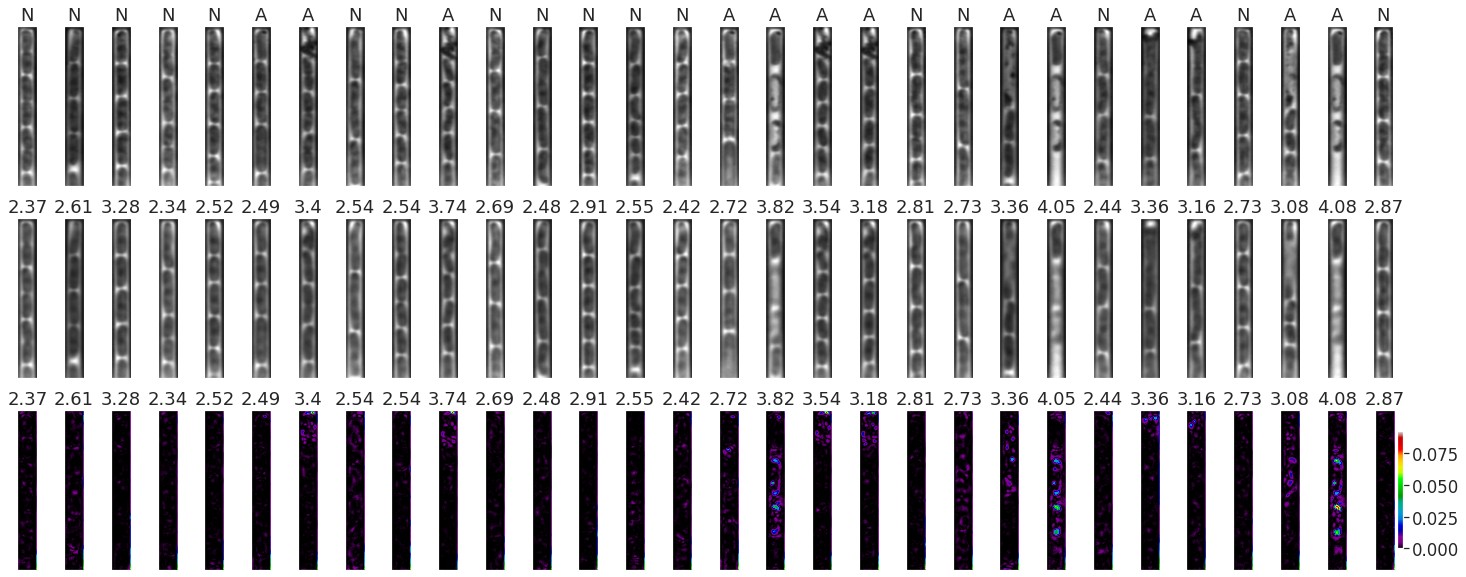

In [27]:
from matplotlib import cm
from matplotlib.colors import Normalize

def plot_images_reconstructions(model, iterator, n_images=15, batch=10):

    fig, axes = plt.subplots(3, n_images, figsize=(25, 10), sharex="all", sharey="all")

    bx, (by, lab) = iterator[batch]
    pred = model.predict(by)
    predictions = np.array(pred)
    y_scores = tf.math.sqrt(tf.reduce_sum((predictions - by) ** 2, axis=(1, 2, 3))).numpy()
    init_idx = 20
    predictions = predictions.squeeze(-1)
    
    for i in range(n_images):
        axes[0][i].imshow(by[init_idx + i].squeeze(-1), cmap=plt.get_cmap("gray"))
        axes[0][i].set_title(set_lab(lab[init_idx + i]))
        axes[1][i].imshow(np.clip(predictions[init_idx + i], 0, 1), cmap=plt.get_cmap("gray"))
        axes[1][i].set_title(round(y_scores[init_idx + i], 2))
        if i == n_images - 1:
            im = axes[2][i].imshow(np.clip((predictions[init_idx + i] - by[init_idx + i].squeeze(-1)) ** 2, 0, 1), cmap=plt.get_cmap("nipy_spectral"))
        else:
            axes[2][i].imshow(np.clip((predictions[init_idx + i] - by[init_idx + i].squeeze(-1)) ** 2, 0, 1), cmap=plt.get_cmap("nipy_spectral"))
        axes[2][i].set_title(round(y_scores[init_idx + i], 2))
        axes[0][i].get_xaxis().set_visible(False)
        axes[1][i].get_yaxis().set_visible(False)
        axes[0][i].get_xaxis().set_ticks([])
        axes[1][i].get_yaxis().set_ticks([])
        axes[2][i].get_xaxis().set_ticks([])
        axes[2][i].get_yaxis().set_ticks([])
        axes[2][i].get_xaxis().set_visible(False)
        axes[2][i].get_yaxis().set_visible(False)
    fig.colorbar(im)

set_lab = lambda l: "N" if l == 0 else "A"

plot_images_reconstructions(vae, x_test, n_images=30, batch=1)
# plt.savefig("/content/drive/My Drive/BACMMAN_DISTNET/UAD_BACT/BACT_one_vs_all/reconstructions_4contr_kl_bis.png")

Bacteria are effectively reconstructed ! We can see that the anomaly score (title of the images below) is highly correlated with anormal character of an image (title over).

In [28]:
def score_samples_iterator(self, dataset_iterator):
    """
    Returns the anomaly scores for data (name of the method inspired from the sklearn
    interface) when data is given in an iterator
    :param dataset_iterator: image or batch of images
    :param decision_function: can be either "distance" to predict anomalies based on their distance to the model's center
    (in an SVDD manner) or "reconstruction" to predict anomalies based on the reconstruction error between the input
    image and the reconstruction (using MSE, in a VAE manner).
    Return: scores in the batch format
    """
    scores = []
    for i in range(len(dataset_iterator)):
        _, (ims, labs) = dataset_iterator[i]
        if (i + 1) % 50 == 0:
            print(f"making predictions on batch {i + 1}...")
        predictions = self.predict(ims)
        y_scores = tf.math.sqrt(tf.reduce_sum((predictions - ims) ** 2, axis=(1, 2, 3)))
        for elt in y_scores:
            scores.append(elt)
    return np.array(scores)


y_scores = score_samples_iterator(vae, x_test)

In [29]:
labs = []
for i in range(len(x_test)):
    _, (_, lab) = x_test[i]
    for elt in lab:
        labs.append(elt)
labs = np.array(labs)

(1011,)


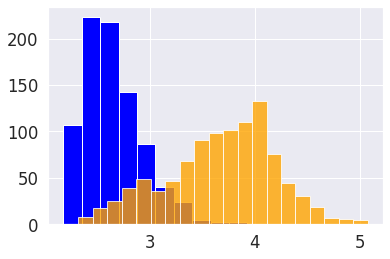

In [30]:
norm_scores = y_scores[labs == 0.]
# anorm_misclass = y_scores[(labs == 1.) & (y_scores <= 1.52)]
anorm_misclass = y_scores[(labs == 1.)]

plt.hist(norm_scores, color='b')
plt.hist(anorm_misclass, color='orange', alpha=0.8, bins=20)

print(anorm_misclass.shape)

(122,)


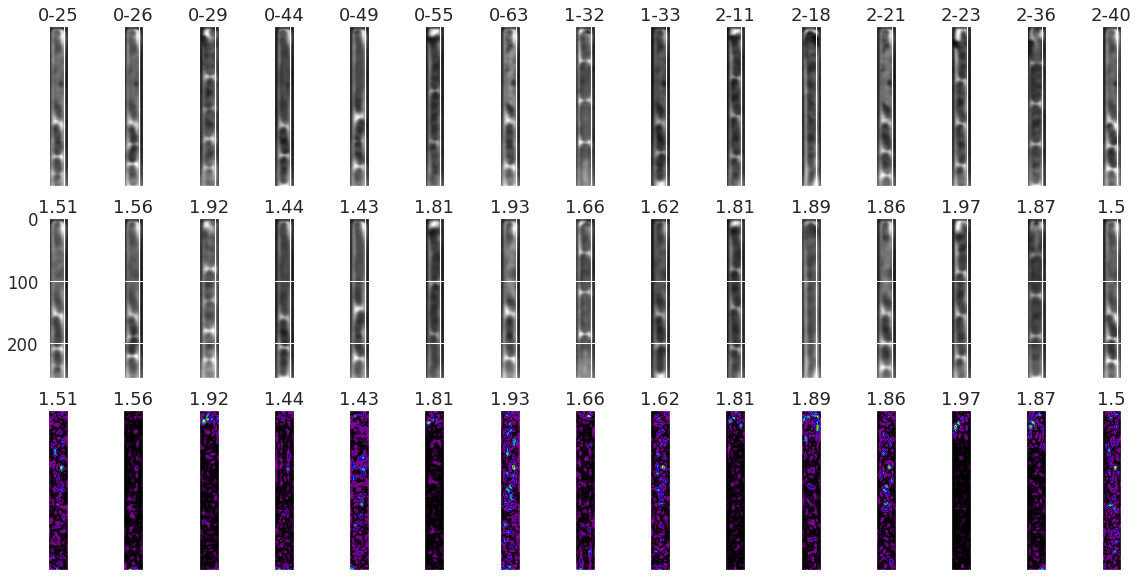

In [ ]:
def plot_misclassified(model, iterator, n_images=15):

    y_scores, labels, predictions = [], [], []
    for i in range(len(iterator)):
        bx, (by, lab) = iterator[i]
        pred = model.predict(by)
        pred = np.array(pred)
        scores = tf.math.sqrt(tf.reduce_sum((pred - by) ** 2, axis=(1, 2, 3))).numpy()
        for l, s, p in zip(lab, scores, pred):
            labels.append(l)
            y_scores.append(s)
            predictions.append(p)

    labels, y_scores, predictions = np.array(labels), np.array(y_scores), np.array(predictions)
    misclass_idx = np.argwhere((labels == 1.) & (y_scores <= 2)).squeeze(-1)
    # misclass_idx = np.argwhere((labels == 0.) & (y_scores > 1.53)).squeeze(-1)
    print(misclass_idx.shape)

    fig, axes = plt.subplots(3, np.min([n_images, misclass_idx.shape[0]]), figsize=(20, 10), sharex="all", sharey="all")

    batch_size = 64

    for i in range(np.min([n_images, misclass_idx.shape[0]])):
        abs_idx = misclass_idx[i]
        batch_idx, idx = abs_idx // batch_size, abs_idx % batch_size
        bx, (by, ly) = iterator[batch_idx]
        axes[0][i].imshow(by[idx].squeeze(-1), cmap=plt.get_cmap("gray"))
        axes[0][i].set_title(f"{batch_idx}-{idx}")
        axes[1][i].imshow(np.clip(predictions[abs_idx].squeeze(-1), 0, 1), cmap=plt.get_cmap("gray"))
        axes[1][i].set_title(round(y_scores[abs_idx], 2))
        axes[2][i].imshow(np.clip((predictions[abs_idx].squeeze(-1) - by[idx].squeeze(-1)) ** 2, 0, 1), cmap=plt.get_cmap("nipy_spectral"))
        axes[2][i].set_title(round(y_scores[abs_idx], 2))
        axes[0][i].get_yaxis().set_visible(False)
        axes[0][i].get_yaxis().set_visible(False)
        axes[2][i].get_xaxis().set_visible(False)
        axes[2][i].get_yaxis().set_visible(False)

set_lab = lambda l: "N" if l == 0 else "A"

plot_misclassified(vae, x_test)

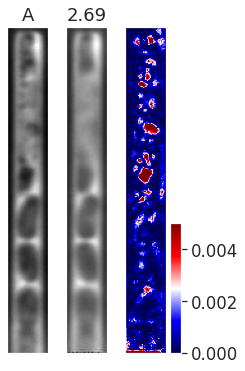

In [36]:
# register images of bacteria

batch, idx = 1, 47
bx, (by, labs) = x_test[batch]
predictions = vae.predict(by)
y_scores = tf.math.sqrt(tf.reduce_sum((predictions - by) ** 2, axis=(1, 2, 3))).numpy()
by, predictions = by.squeeze(-1), predictions.squeeze(-1)

fig, axes = plt.subplots(1, 3, figsize=(3, 6), sharex="all", sharey="all")
axes[0].imshow(by[idx], cmap=plt.get_cmap("gray"))
axes[0].set_title(set_lab(labs[idx]))
axes[1].imshow(predictions[idx], cmap=plt.get_cmap("gray"))
axes[1].set_title(round(y_scores[idx], 2))
res = axes[2].imshow((predictions[idx] - by[idx]) ** 2, cmap=plt.get_cmap("seismic"), vmin=0, vmax=0.005)
cax = fig.add_axes([0.9, 0.125, 0.05, 0.3])  # left, bottom, width, height
plt.colorbar(res, cax=cax)
# plt.clim(0,0.04)
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)

plt.savefig("/content/drive/My Drive/BACMMAN_DISTNET/imgs/5contr_better_erasing_Y.png")

## Compute ROC

(1862,) [3.5280278 2.7343721 2.6707826 2.0008025 2.656694  2.641827  2.6876018
 2.7835546 2.3216536 2.4700785]


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f915e094a58>)

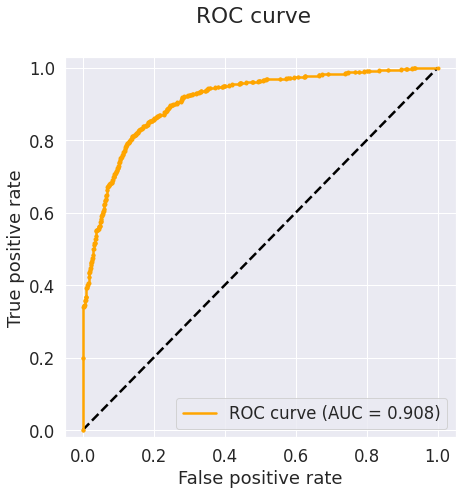

In [39]:
from uad.diagnostic.metrics import plot_ROC, is_binary, binarize_set
from sklearn.metrics import roc_curve

def score_samples_iterator(self, dataset_iterator):
    """
    Returns the anomaly scores for data (name of the method inspired from the sklearn
    interface) when data is given in an iterator
    :param dataset_iterator: image or batch of images
    :param decision_function: can be either "distance" to predict anomalies based on their distance to the model's center
    (in an SVDD manner) or "reconstruction" to predict anomalies based on the reconstruction error between the input
    image and the reconstruction (using MSE, in a VAE manner).
    Return: scores in the batch format
    """
    scores = []
    for i in range(len(dataset_iterator)):
        _, (ims, labs) = dataset_iterator[i]
        if (i + 1) % 50 == 0:
            print(f"making predictions on batch {i + 1}...")
        predictions = self.predict(ims)
        y_scores = tf.math.sqrt(tf.reduce_sum((predictions - ims) ** 2, axis=(1, 2, 3)))
        for elt in y_scores:
            scores.append(elt)
    return np.array(scores)


def compute_ROC_iterator(self, dataset_iterator, interest_digit=0):
    """
    :param dataset_iterator:
    :param decision_function:
    :param batch:
    :param interest_digit:
    :return:
    """
    labels = []
    for i in range(len(dataset_iterator)):
        _, (ims, y_true) = dataset_iterator[i]
        for elt in y_true:
            labels.append(elt)

    y_trues = np.array(labels).flatten()
    y_scores = score_samples_iterator(self, dataset_iterator).flatten()

    print(y_scores.shape, y_scores[:10])

    fpr, tpr, thresholds = roc_curve(y_trues, y_scores, pos_label=1)

    return fpr, tpr, thresholds

fpr, tpr, _ = compute_ROC_iterator(vae, x_test, interest_digit=0)
plot_ROC(fpr, tpr)
# plt.savefig("/content/drive/My Drive/BACMMAN_DISTNET/imgs/roc_curve.PNG")

1. 4 contractions, 64 initial filters, without self-attention. Only leaky relu and no output activation (linear) : AUC = [0.954, 0.946, 0.94 (KL weight == 10), 0.961, 0.957, 0.964, 0.966, 0.949, 0.953, 0.958] after 50 epochs. (12 million parameters)
1. bis Idem but with KL weight = 5. AUC = 0.941 but interesting results, seems like the anomalies are less well reconstructed.
2. 3 contractions, 64 initial filters, self-attention. Idem for activations : AUC = 0.94. (4 million parameters, 40 seconds per epoch on T4, converged after 35 epochs);
3. 4 contractions, 64 initial_filters, self_attention. Idem for activations : AUC = [0.954, 948] after 50 epochs. (20 million parameters, 1 minute per epoch on T4)
4. 5 contractions, 64 initial filters, without self-attention. Idem for activations. AUC = [0.955, 0.962, 0.965, 0.947, 0.912] after 50 epochs (40 million parameters, 1.5 minute/epoch). Looks to overfit a bit but there is a real difference on x_test between the anomaly scores of the anormal class and the anomaly scores of the normal class.

In [ ]:
ar = np.array([0.954, 0.946, 0.94, 0.961, 0.957, 0.964, 0.966, 0.949, 0.953, 0.958])
mean, std = np.mean(ar, axis=0), np.std(ar, axis=0)
print(mean * 100, std * 100)

95.48 0.7730459236035082


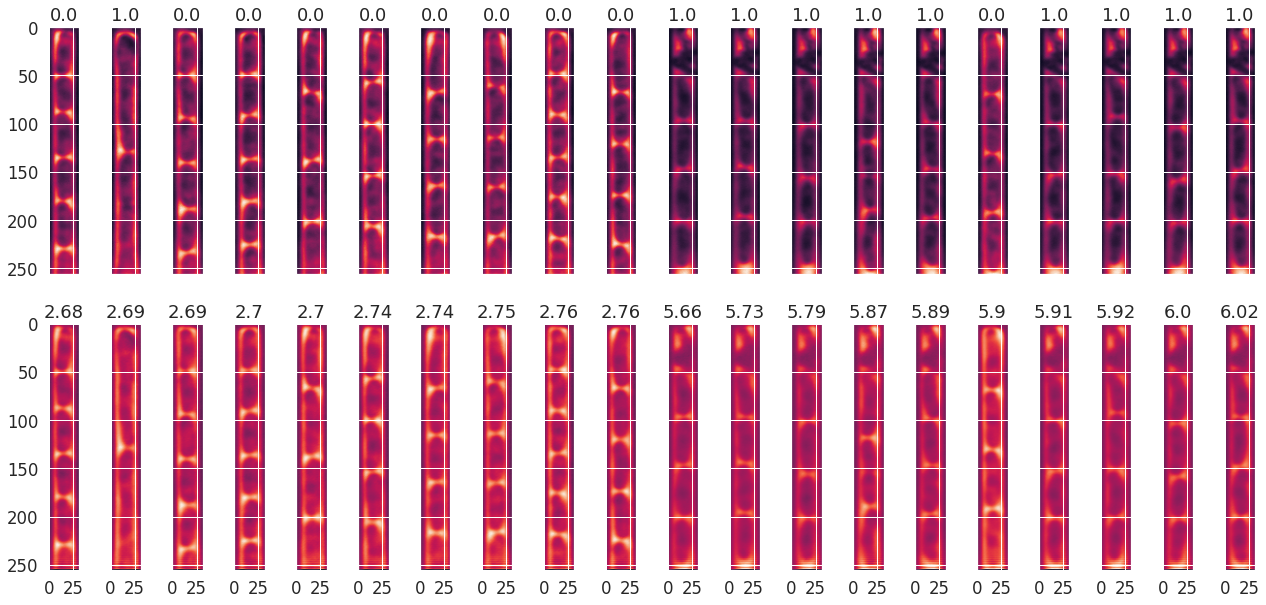

In [ ]:

y_scores = score_samples_iterator(vae, x_test)
sorted_indices = np.argsort(y_scores)
interest = np.concatenate((sorted_indices[:10], sorted_indices[-10:]), axis=0)

batch_size = 64

fig, axes = plt.subplots(2, 20, figsize=(22, 10), sharex="all", sharey="all")

for i, elt in enumerate(interest):
    bat_idx, idx = elt // batch_size, elt % batch_size
    bx, (by, lab) = x_test[bat_idx]
    preds = vae.predict(by)
    axes[0][i].imshow(by[idx].squeeze(-1))
    axes[1][i].imshow(preds[idx].squeeze(-1))
    axes[1][i].set_title(round(y_scores[elt], 2))
    axes[0][i].set_title(lab[idx])

# plt.savefig("/content/drive/My Drive/BACMMAN_DISTNET/UAD_BACT/BACT_one_vs_all/10lowest_10highest_4contr_kl.png")

## Plot scores distribution

851 normal examples
1011 normal examples


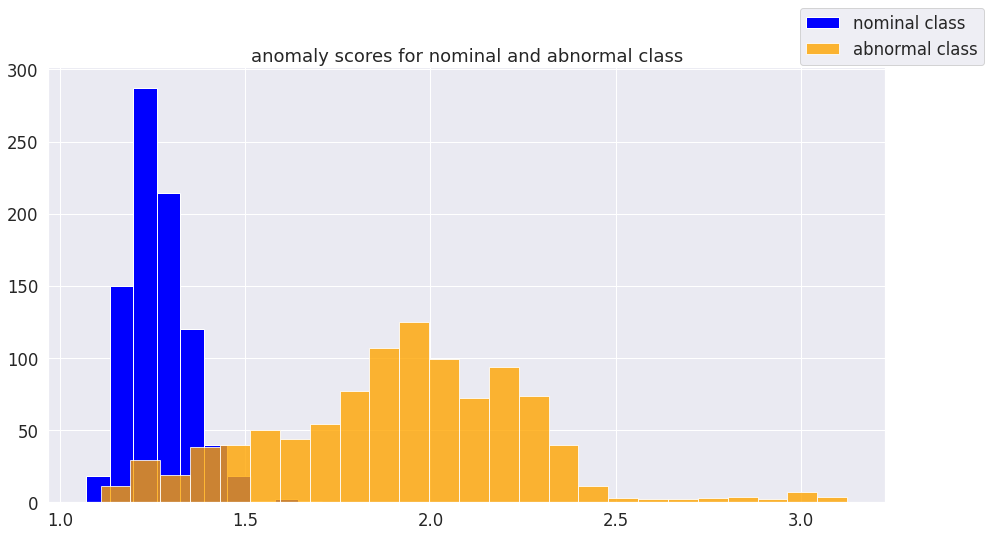

In [ ]:
def plot_scores_distrib(self, dataset_iterator):
    """
    Plot the distribution of anomaly scores computed on dataset_iterator, for
    the normal class and for the anormal class
    :param dataset_iterator:
    :param interest_class:
    :return:
    """
    y_trues = []
    for i in range(len(dataset_iterator)):
        _, (ims, labs) = dataset_iterator[i]
        for lab in labs:
            y_trues.append(lab)
    y_trues = np.array(y_trues)
    sc = score_samples_iterator(self, dataset_iterator).flatten()

    scores_nominal = sc[y_trues == 0.]
    scores_anormal = sc[y_trues == 1.]

    print(f"{scores_nominal.shape[0]} normal examples")
    print(f"{scores_anormal.shape[0]} normal examples")

    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    ax.hist(scores_nominal, color="b", label="nominal class", bins=10)
    ax.set_title("anomaly scores for nominal and abnormal class")
    ax.hist(scores_anormal, color="orange", label="abnormal class", bins=25, alpha=0.8)
    fig.legend()
    return fig, axes

plot_scores_distrib(vae, x_test)

plt.savefig("/content/drive/My Drive/BACMMAN_DISTNET/imgs/anomaly_scores.png")

We effectively have different anomaly score distributions for both classes!

## Plot t-SNE of the latent space

t-SNE inputs shape: (1862, 32768)
t-SNE output shape: (1862, 2)
2


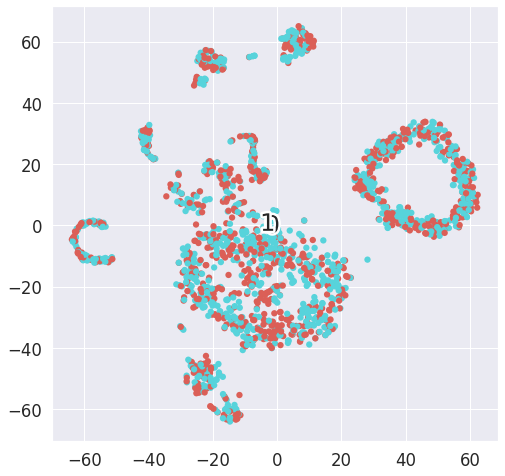

In [ ]:
from uad.diagnostic.visualisation import plot_tSNE

z_means, _, _ = vae.encoder.predict(x_test)

labels = []
for k in range(len(x_test)):
    bx, (by, labs) = x_test[k]
    for lab in labs:
        labels.append(lab)
    
labels = np.array(labels).flatten()

fig, axes, scs, txt = plot_tSNE(z_means, labels, axis=0, plot_center=np.array([False]))

Classes are not separated in the latent space...